In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import math
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
for dirpath, dirnames, filenames in os.walk("../img_preparation/img_augment_384/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 0 directories and 2380 images in ../img_preparation/img_augment_384/ 


In [3]:
def load_data_batch(ids, batch_size, channel, path):
    
    '''
        This function create a batch of training data
    '''
    
    data = pd.read_csv(path + '/label.csv')

    path = path + '/'
    
    image_batch = np.zeros((batch_size, 384, 384, channel))
    
    label_values = np.zeros((batch_size, 1))
    batch_ids = np.random.choice(ids, batch_size)
    
    ind = 0
    for i in range(1,len(batch_ids)):
        im = Image.open(path + str(batch_ids[i]) + '.jpg')
            
    
        im = np.array(im)
        # print(im.shape)
        image_batch[ind] = im
        label_values[ind] = (data['Value'][data.index==batch_ids[i]])
        ind += 1
            
    return (np.array(image_batch), np.array(label_values))

In [4]:
data_num = 2378
data_ids = np.arange(data_num)+1  # image data starts with 1
data_ids[:5]

array([1, 2, 3, 4, 5])

In [6]:
X, y = load_data_batch(ids=data_ids,
                       batch_size=len(data_ids),
                       channel=3,
                       path="../img_preparation/img_augment_384")

In [7]:
X_norm = X/255.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_test.shape

((1902, 384, 384, 3), (476, 384, 384, 3))

In [10]:
n_row = X_train.shape[1]
n_col = X_train.shape[2]
n_channel = X_train.shape[3]
n_row, n_col, n_channel

(384, 384, 3)

## Model

In [30]:
#Create model
input = Input(shape = (n_row, n_col,n_channel))
conv1 = Conv2D(50,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(100,3,activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(150,3,activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(200,3,activation='relu')(pool2)
dropou4 = Dropout(.4)(conv4)

flat = Flatten()(pool2)

output = Dense(100, activation='relu')(flat)
output = Dense(200, activation='relu')(output)
output = Dense(1, activation='linear', name="minor")(output)

model = Model(inputs=input, outputs=[output])

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-19 09:30:33.280407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-19 09:30:33.281414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [40]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(loss=["mse"], 
              optimizer=adam,
              metrics=["mse"])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 382, 382, 50)      1400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 191, 50)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 189, 100)     45100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 94, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 883600)            0     

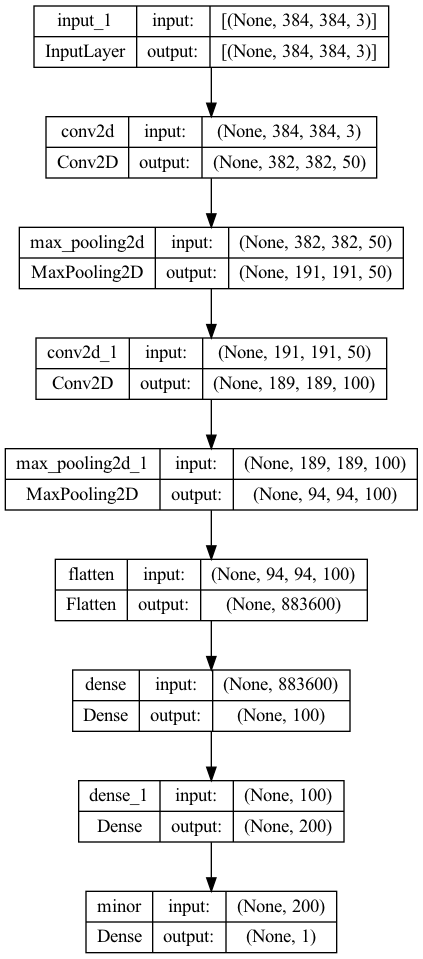

In [42]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [43]:
history_1 =  model.fit(X_train, y_train,
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_test, y_test))

Epoch 1/5


2022-10-19 09:49:19.984736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 1.0897 - mse: 1.0897

2022-10-19 09:50:37.947478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 88s 1s/step - loss: 1.0897 - mse: 1.0897 - val_loss: 0.5615 - val_mse: 0.5615
Epoch 2/5
60/60 [==============================] - 100s 2s/step - loss: 0.3370 - mse: 0.3370 - val_loss: 0.3879 - val_mse: 0.3879
Epoch 3/5
60/60 [==============================] - 117s 2s/step - loss: 0.2402 - mse: 0.2402 - val_loss: 0.3372 - val_mse: 0.3372
Epoch 4/5
60/60 [==============================] - 120s 2s/step - loss: 0.1648 - mse: 0.1648 - val_loss: 0.2828 - val_mse: 0.2828
Epoch 5/5
60/60 [==============================] - 116s 2s/step - loss: 0.1241 - mse: 0.1241 - val_loss: 0.2705 - val_mse: 0.2705


In [40]:
# Plot the validation and training curve separately
def plot_loss_curve(history):
  """
  Returns separate loss curve for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]


  epochs = range(len(history.history["loss"])) 

  # Plot loss 
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

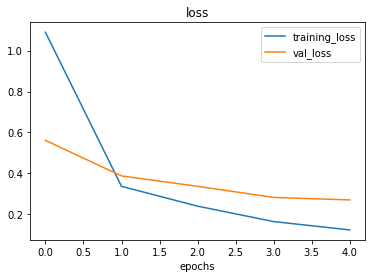

In [46]:
plot_loss_curve(history_1)

In [39]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 10s 580ms/step - loss: 0.5770


0.5770020484924316

## Make a prediction

In [41]:
# Create a function to import an image and resize 
def load_and_prep_image(filename, img_shape=384):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [42]:
# Create function plot
def pred_and_plot(model, filename):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))[0][0]


  # Plot the image and predicted class
  plt.figure(figsize=(10,7))
  plt.imshow(img)
  plt.title("Prediction: {:.2f}".format(pred))
  plt.axis(False)

1/1 [==============================] - 0s 20ms/step


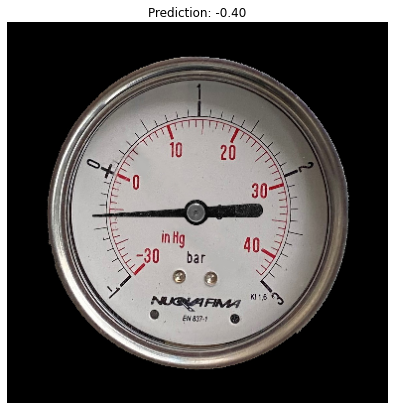

In [65]:
pred_and_plot(model,"../img_preparation/gauges/gauge_-0.4.png")

1/1 [==============================] - 0s 26ms/step


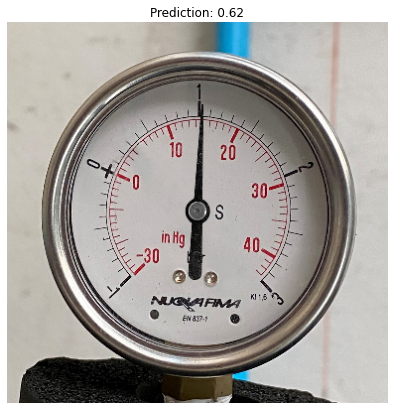

In [70]:
pred_and_plot(model,"../img_preparation/gauge_0 2.png")

1/1 [==============================] - 0s 41ms/step


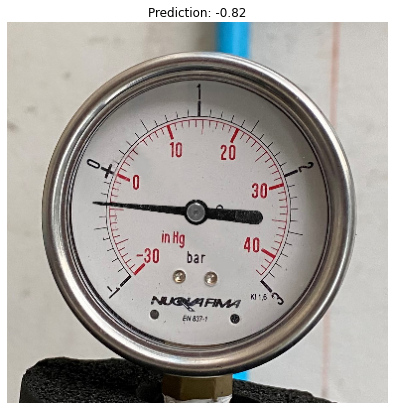

In [69]:
pred_and_plot(model, "../img_preparation/gauge_0.png")

1/1 [==============================] - 0s 19ms/step


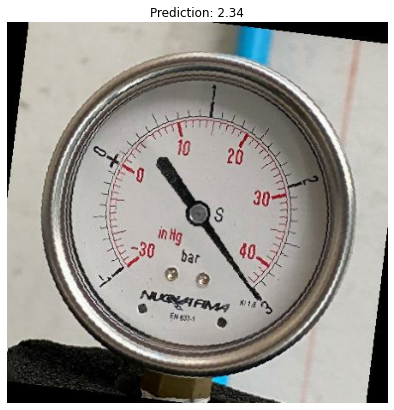

In [68]:
pred_and_plot(model, "../img_preparation/1875.jpg")

1/1 [==============================] - 0s 16ms/step


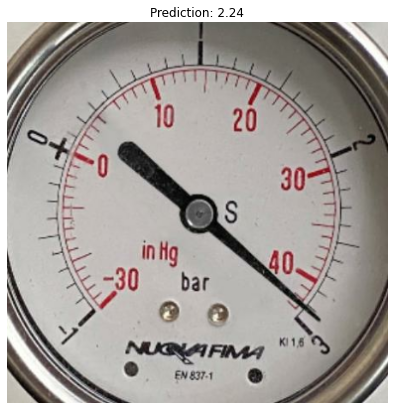

In [71]:
pred_and_plot(model, "../img_preparation/1813.jpg")

## Model 2

In [16]:
#Create model
input = Input(shape = (n_row, n_col,n_channel))
conv1 = Conv2D(50,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
batch1 = BatchNormalization()(pool1)

conv2 = Conv2D(100,3,activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
batch2 = BatchNormalization()(pool2)

conv3 = Conv2D(150,3,activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(200,3,activation='relu')(pool2)
dropou4 = Dropout(.4)(conv4)

flat = Flatten()(pool2)

output = Dense(100, activation='relu')(flat)
output = Dense(200, activation='relu')(output)
output = Dense(1, activation='linear')(output)

model2 = Model(inputs=input, outputs=[output])

In [17]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model2.compile(loss=["mse"], 
              optimizer=adam,
              metrics=["mse"])

In [18]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 382, 382, 50)      1400      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 191, 191, 50)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 189, 189, 100)     45100     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 94, 94, 100)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 883600)            0   

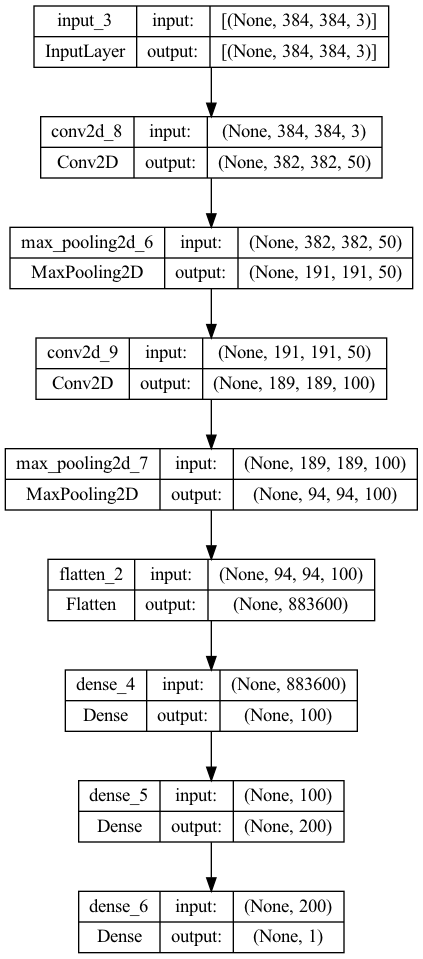

In [19]:
plot_model(model2, show_shapes=True, show_layer_names=True)

In [20]:
history_2 =  model2.fit(X_train, y_train,
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_test, y_test))

Epoch 1/5


2022-10-24 01:23:45.135409: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-24 01:23:46.467114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 103.7341 - mse: 103.7341

2022-10-24 01:25:03.260717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 86s 1s/step - loss: 103.7341 - mse: 103.7341 - val_loss: 1.4086 - val_mse: 1.4086
Epoch 2/5
60/60 [==============================] - 77s 1s/step - loss: 1.3959 - mse: 1.3959 - val_loss: 1.3945 - val_mse: 1.3945
Epoch 3/5
60/60 [==============================] - 76s 1s/step - loss: 1.3784 - mse: 1.3784 - val_loss: 1.3977 - val_mse: 1.3977
Epoch 4/5
60/60 [==============================] - 76s 1s/step - loss: 1.3479 - mse: 1.3479 - val_loss: 1.3350 - val_mse: 1.3350
Epoch 5/5
60/60 [==============================] - 165s 3s/step - loss: 1.2904 - mse: 1.2904 - val_loss: 1.2707 - val_mse: 1.2707


## Model3

In [21]:

input = Input(shape = (n_row,n_col,n_channel))
conv1 = Conv2D(10,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(10,3,activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(10,3,activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

flat = Flatten()(pool3)

output = Dense(100, activation='relu')(flat)
output = Dense(200, activation='relu')(output)
output = Dense(1, activation='linear')(output)

model3 = Model(inputs=input, outputs=[output])

In [25]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model3.compile(loss=["mse"], 
              optimizer=adam,
              metrics=["mse"])

In [26]:
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 382, 382, 10)      280       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 191, 191, 10)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 189, 189, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 94, 94, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 92, 92, 10)        910 

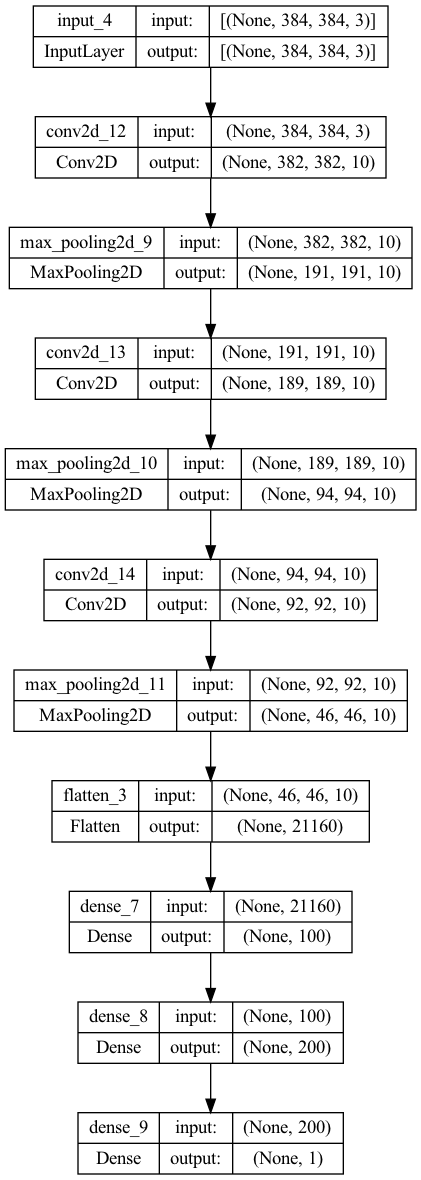

In [24]:
plot_model(model3, show_shapes=True, show_layer_names=True)

In [27]:
history_3 =  model3.fit(X_train, y_train,
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_test, y_test))

Epoch 1/5


2022-10-24 01:35:54.178659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 1.6978 - mse: 1.6978

2022-10-24 01:36:12.023023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 19s 310ms/step - loss: 1.6978 - mse: 1.6978 - val_loss: 1.4331 - val_mse: 1.4331
Epoch 2/5
60/60 [==============================] - 13s 218ms/step - loss: 1.2641 - mse: 1.2641 - val_loss: 1.1605 - val_mse: 1.1605
Epoch 3/5
60/60 [==============================] - 13s 217ms/step - loss: 0.7628 - mse: 0.7628 - val_loss: 0.5630 - val_mse: 0.5630
Epoch 4/5
60/60 [==============================] - 13s 218ms/step - loss: 0.4440 - mse: 0.4440 - val_loss: 0.4266 - val_mse: 0.4266
Epoch 5/5
60/60 [==============================] - 13s 216ms/step - loss: 0.3462 - mse: 0.3462 - val_loss: 0.2799 - val_mse: 0.2799


## Model4

In [28]:
input = Input(shape = (n_row,n_col,n_channel))
conv1 = Conv2D(10,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
batch1 = BatchNormalization()(pool1)

conv2 = Conv2D(10,3,activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
batch2 = BatchNormalization()(pool2)

conv3 = Conv2D(10,3,activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

flat = Flatten()(pool3)

output = Dense(100, activation='relu')(flat)
output = Dense(200, activation='relu')(output)
output = Dense(1, activation='linear')(output)

model4 = Model(inputs=input, outputs=[output])

In [31]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model4.compile(loss=["mse"], 
              optimizer=adam,
              metrics=["mse"])

In [29]:
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 382, 382, 10)      280       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 191, 191, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 189, 189, 10)      910       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 94, 94, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 92, 92, 10)        910 

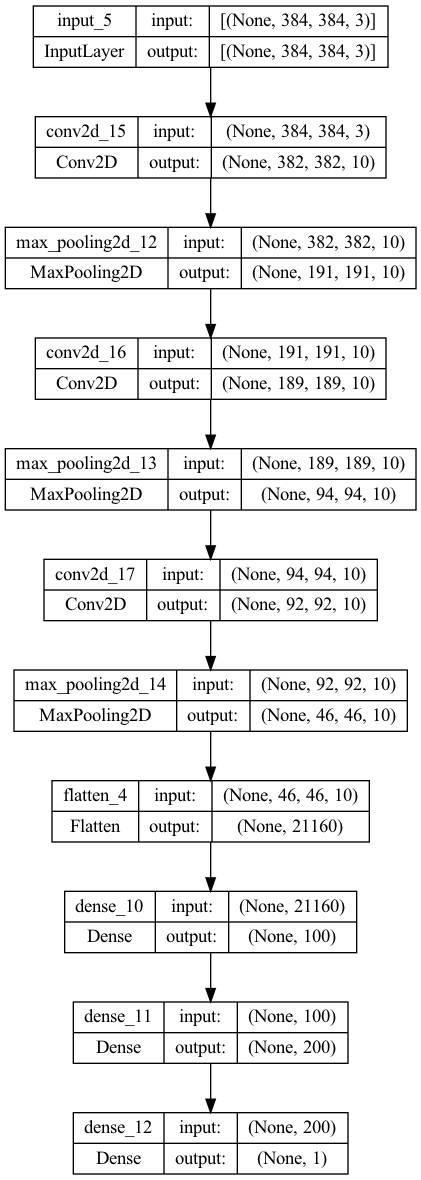

In [30]:
plot_model(model4, show_shapes=True, show_layer_names=True)

In [32]:
history_4 =  model4.fit(X_train, y_train,
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_test, y_test))

Epoch 1/5


2022-10-24 01:40:19.443504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 1.9045 - mse: 1.9045

2022-10-24 01:40:36.977698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 19s 302ms/step - loss: 1.9045 - mse: 1.9045 - val_loss: 1.5248 - val_mse: 1.5248
Epoch 2/5
60/60 [==============================] - 13s 219ms/step - loss: 1.3453 - mse: 1.3453 - val_loss: 1.2187 - val_mse: 1.2187
Epoch 3/5
60/60 [==============================] - 13s 218ms/step - loss: 0.9615 - mse: 0.9615 - val_loss: 0.7472 - val_mse: 0.7472
Epoch 4/5
60/60 [==============================] - 13s 217ms/step - loss: 0.5549 - mse: 0.5549 - val_loss: 0.4445 - val_mse: 0.4445
Epoch 5/5
60/60 [==============================] - 13s 216ms/step - loss: 0.4279 - mse: 0.4279 - val_loss: 0.4296 - val_mse: 0.4296


## Model5

In [33]:
model5 = tf.keras.models.clone_model(model3)

In [36]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model5.compile(loss=["mse"], 
              optimizer=adam,
              metrics=["mse"])

In [34]:
model5.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 382, 382, 10)      280       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 191, 191, 10)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 189, 189, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 94, 94, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 92, 92, 10)        910 

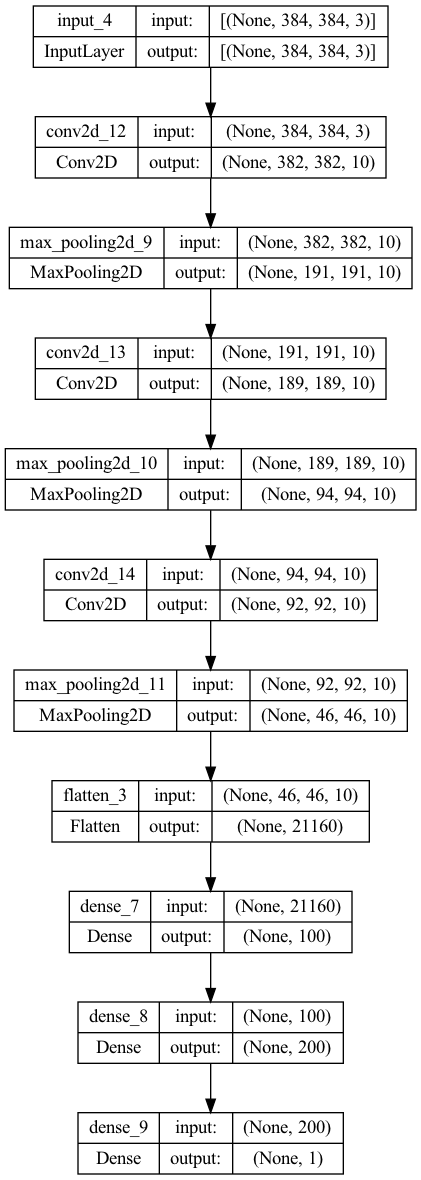

In [37]:
plot_model(model5, show_shapes=True, show_layer_names=True)

In [38]:
history_5 =  model5.fit(X_train, y_train,
                       epochs=30,
                       batch_size=32,
                       validation_data=(X_test, y_test))

Epoch 1/30


2022-10-24 01:44:23.436465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 1.5815 - mse: 1.5815

2022-10-24 01:44:40.511901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 19s 299ms/step - loss: 1.5815 - mse: 1.5815 - val_loss: 1.5423 - val_mse: 1.5423
Epoch 2/30
60/60 [==============================] - 13s 217ms/step - loss: 1.3059 - mse: 1.3059 - val_loss: 1.2127 - val_mse: 1.2127
Epoch 3/30
60/60 [==============================] - 13s 218ms/step - loss: 0.9587 - mse: 0.9587 - val_loss: 0.6562 - val_mse: 0.6562
Epoch 4/30
60/60 [==============================] - 13s 218ms/step - loss: 0.4993 - mse: 0.4993 - val_loss: 0.4315 - val_mse: 0.4315
Epoch 5/30
60/60 [==============================] - 13s 216ms/step - loss: 0.4232 - mse: 0.4232 - val_loss: 0.3750 - val_mse: 0.3750
Epoch 6/30
60/60 [==============================] - 13s 217ms/step - loss: 0.3836 - mse: 0.3836 - val_loss: 0.4026 - val_mse: 0.4026
Epoch 7/30
60/60 [==============================] - 13s 217ms/step - loss: 0.3265 - mse: 0.3265 - val_loss: 0.4096 - val_mse: 0.4096
Epoch 8/30
60/60 [==============================] - 13s 218ms/step - loss: 0.287

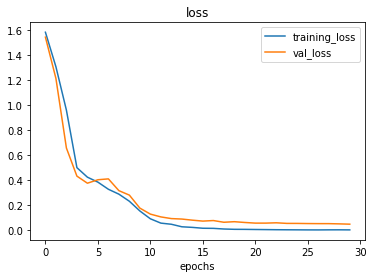

In [43]:
plot_loss_curve(history_5)

In [44]:
model5.evaluate(X_test, y_test)

15/15 [==============================] - 1s 67ms/step - loss: 0.0474 - mse: 0.0474


[0.04744803532958031, 0.04744803532958031]

2022-10-24 02:05:50.419011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 791ms/step


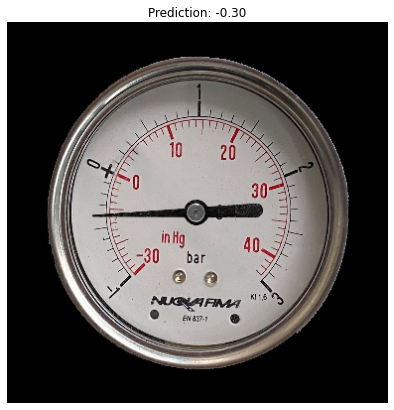

In [45]:
pred_and_plot(model5,"../img_preparation/gauges/gauge_-0.4.png")

1/1 [==============================] - 0s 11ms/step


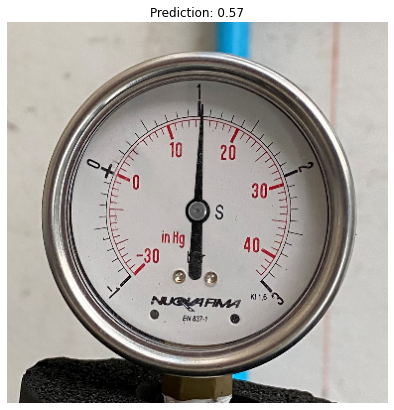

In [46]:
pred_and_plot(model5,"../img_preparation/gauge_0 2.png")

1/1 [==============================] - 0s 13ms/step


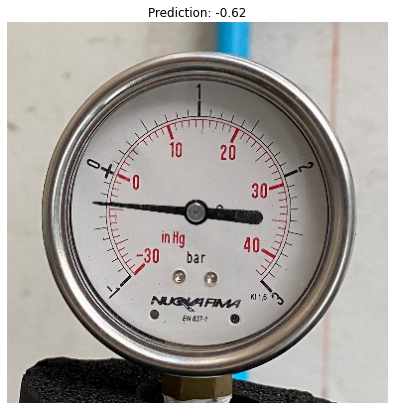

In [47]:
pred_and_plot(model5, "../img_preparation/gauge_0.png")

1/1 [==============================] - 0s 12ms/step


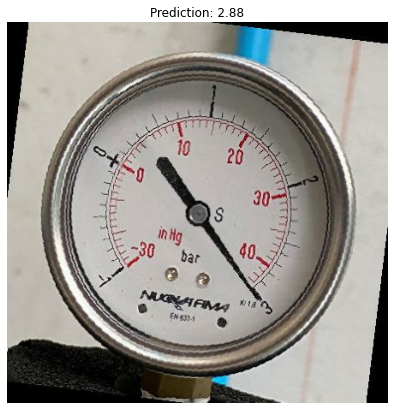

In [49]:
pred_and_plot(model5, "../img_preparation/1875.jpg")

1/1 [==============================] - 0s 43ms/step


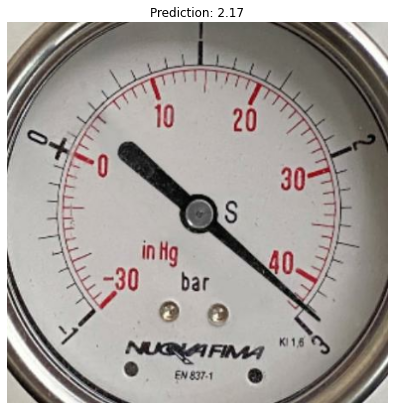

In [50]:
pred_and_plot(model5, "../img_preparation/1813.jpg")